# <span style='font-family:"Times New Roman"'> <span styel=''>**ANALYSE MISSING SAMPLES (NA)**
*Emile Cohen*
    
 *April 2020*

**Goal:** In this notebook, we compute numbers, general distributions for the samples that are missing purity but have a tp53 mutation.

The notebook is composed of 2 parts:

---

In [30]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
from itertools import cycle, islice

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

# Loading the data

In [3]:
maf_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')
#gene_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.arm_level.txt', sep='\t')
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')

In [5]:
maf_cohort.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND_VEP,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,flanking_bps,variant_id,variant_qual,ExAC_AF_Adj,ExAC_AC_AN_Adj,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER,Caller,is-a-hotspot,is-a-3d-hotspot,mutation_effect,oncogenic,LEVEL_1,LEVEL_2A,LEVEL_2B,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,LEVEL_R3,Highest_level,citations,driver,tcn,lcn,cf,purity,t_var_freq,expected_alt_copies,ccf_Mcopies,ccf_Mcopies_lower,ccf_Mcopies_upper,ccf_Mcopies_prob95,ccf_Mcopies_prob90,ccf_1copy,ccf_1copy_lower,ccf_1copy_upper,ccf_1copy_prob95,ccf_1copy_prob90,ccf_expected_copies,ccf_expected_copies_lower,ccf_expected_copies_upper,ccf_expected_copies_prob95,ccf_expected_copies_prob90,facets_fit,reviewer_set_purity,use_only_purity_run,use_edited_cncf,cncf_file_used
0,IKBKE,9641,MSKCC,GRCh37,1,206646650,206646650,+,Missense_Mutation,SNP,G,G,A,novel,NaN,P-0034223-T01-IM6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,NaN,NaN,c.80G>A,p.Arg27His,p.R27H,ENST00000367120,3/22,1279.0,1027.0,252.0,809,809,0,"IKBKE,missense_variant,p.Arg27His,ENST00000367120,NM_014002.3,NM_001193322.1;IKBKE,intron_variant,,ENST00000537984,NM_001193321.1;IKBKE,intron_variant,,ENST00000463979,;",A,ENSG00000143466,ENST00000367120,Transcript,missense_variant,453/3269,80/2151,27/716,R/H,cGc/cAc,NaN,1,NaN,1,IKBKE,HGNC,14552.0,protein_coding,YES,CCDS30996.1,ENSP00000356087,Q14164,NaN,UPI0000033727,"NM_014002.3,NM_001193322.1",deleterious(0),probably_damaging(1),3/22,NaN,"Gene3D:3.30.200.20,Pfam_domain:PF00069,PROSITE_patterns:PS00107,PROSITE_profiles:PS50011,hmmpanther:PTHR22969,hmmpanther:PTHR22969:SF10,SMART_domains:SM00220,Superfamily_domains:SSF56112",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,indel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CGC,.,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,4.0,1.0,0.946448,0.946448,0.197029,1.0,0.270,0.252,0.289,2.574074e-293,3.629664e-249,0.810,0.757,0.866,0.001839,0.030659,0.810,0.757,0.866,0.001839,0.030659,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default,NaN,False,False,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6_hisens.cncf.txt
1,PIK3CA,5290,MSKCC,GRCh37,3,178936091,178936091,+,Missense_Mutation,SNP,G,G,A,novel,NaN,P-0034223-T01-IM6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,NaN,NaN,c.1633G>A,p.Glu545Lys,p.E545K,ENST00000263967,10/21,618.0,334.0,284.0,160,160,0,"PIK3CA,missense_variant,p.Glu545Lys,ENST

In [6]:
arm_level.head()

,sample,arm,tcn,lcn,cn_length,arm_length,frac_of_arm,cn_state
0,P-0034223-T01-IM6_P-0034223-N01-IM6,1p,2,1,120534257,120534257,1.00,DIPLOID
1,P-0034223-T01-IM6_P-0034223-N01-IM6,1q,4,1,101461100,125135032,0.81,GAIN
2,P-0034223-T01-IM6_P-0034223-N01-IM6,2p,2,1,87764506,87764506,1.00,DIPLOID
3,P-0034223-T01-IM6_P-0034223-N01-IM6,2q,2,1,150656179,150656179,1.00,DIPLOID
4,P-0034223-T01-IM6_P-0034223-N01-IM6,3p,2,1,89055004,89055004,1.00,DIPLOID


In [7]:
annotated_cohort.head()

,sample_id,sample_path,fit_to_use,patient,tumor_sample,tumor_bamname,normal_sample,normal_bamname,tag,run_prefix,run_output_dir,run_log_dir,counts_file,has_counts_file,has_hisens_run,has_purity_run,has_qc,has_maf_anno,run_status,tumor_sample_id,path,fit_name,purity_run_version,purity_run_prefix,purity_run_Seed,purity_run_cval,purity_run_nhet,purity_run_snp_nbhd,purity_run_ndepth,purity_run_Purity,purity_run_Ploidy,purity_run_dipLogR,purity_run_alBalLogR,hisens_run_version,hisens_run_prefix,hisens_run_Seed,hisens_run_cval,hisens_run_nhet,hisens_run_snp_nbhd,hisens_run_ndepth,hisens_run_hisens,hisens_run_Ploidy,hisens_run_dipLogR,manual_note,is_best_fit,purity,ploidy,dipLogR,dipLogR_flag,n_alternative_dipLogR,wgd,n_dip_bal_segs,frac_dip_bal_segs,n_dip_imbal_segs,frac_dip_imbal_segs,n_amps,n_homdels,frac_homdels,n_homdels_clonal,frac_homdels_clonal,n_cn_states,n_segs,n_cnlr_clusters,n_lcn_na,n_loh,frac_loh,n_segs_subclonal,frac_segs_subclonal,n_segs_below_dipLogR,frac_below_dipLogR,n_segs_balanced_odd_tcn,frac_balanced_odd_tcn,n_segs_imbalanced_diploid_cn,frac_imbalanced_diploid_cn,n_segs_lcn_greater_mcn,frac_lcn_greater_mcn,n_snps,n_het_snps,frac_het_snps,n_snps_with_300x_in_tumor,n_het_snps_with_300x_in_tumor,n_het_snps_hom_in_tumor_1pct,n_het_snps_hom_in_tumor_5pct,frac_het_snps_hom_in_tumor_1pct,frac_het_snps_hom_in_tumor_5pct,mean_cnlr_residual,sd_cnlr_residual,n_segs_discordant_tcn,frac_discordant_tcn,n_segs_discordant_lcn,frac_discordant_lcn,n_segs_discordant_both,frac_discordant_both,n_segs_icn_cnlor_discordant,frac_icn_cnlor_discordant,mafr_median_all,mafr_median_clonal,mafr_n_gt_1,facets_suite_version,facets_qc_version,homdel_filter_pass,diploid_bal_seg_filter_pass,diploid_imbal_seg_filter_pass,waterfall_filter_pass,hyper_seg_filter_pass,high_ploidy_filter_pass,valid_purity_filter_pass,diploid_seg_filter_pass,em_cncf_icn_discord_filter_pass,dipLogR_too_low_filter_pass,subclonal_genome_filter_pass,icn_allelic_state_concordance_filter_pass,contamination_filter_pass,facets_qc,arm_level_file,gene_level_file,ccf_file,arm_level_file_exists,gene_level_file_exists,ccf_file_exists
0,P-0034223-T01-IM6_P-0034223-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/,NaN,P-0034223,P-0034223-T01-IM6,JU212898-T,P-0034223-N01-IM6,NL131958-N,P-0034223-T01-IM6_P-0034223-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/default/,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/default/logs/,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/countsMerged____P-0034223-T01-IM6_P-0034223-N01-IM6.dat.gz,True,True,True,False,False,complete,P-0034223-T01-IM6_P-0034223-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/,default,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6_purity,100,100,15,250,35,0.94,2.2,-0.16,-0.16,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6_hisens,100,50,15,250,35,NaN,2.2,-0.16,NaN,False,0.941111,2.241830,-0.155483,False,0,False,12,0.590,0,0.000,0,0,0.0000,0,0.0000,6,31,10,2,4,0.062,1,0.000011,11,0.26,0,0.000000,0,0.000,7,0.110,22963,2655,0.12,6450,634,43,80,0.0160,0.03,-0.190,0.63,1,0.0038,0.0,0.0,0,0.00,1,0.0420,0.0042,0.0034,5,2.0.5,1,True,True,False,True,True,True,True,True,True,True,True,True,True,True,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6.arm_level.txt,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6.gene_

In [4]:
# Number of samples in the entire cohort
print( 'Number of samples in the entire cohort :' + str(len(set(maf_cohort.Tumor_Sample_Barcode))))
print( 'Number of samples without purity estimate (NA or 0.3) : ' + str(len(set(maf_cohort[(maf_cohort.purity == 0.3)| (maf_cohort.purity.isna())].Tumor_Sample_Barcode))))

Number of samples in the entire cohort :38465
Number of samples without purity estimate (NA or 0.3) : 6437


In [19]:
# We filter the samples that have no purity
maf_cohort_na = maf_cohort[(maf_cohort.purity == 0.3)| (maf_cohort.purity.isna())]

# How many samples with a TP53 mutation ?
maf_cohort_na_tp53 = maf_cohort_na[maf_cohort_na['Hugo_Symbol'] == 'TP53']
print('Number of NA purity samples with a TP53 mutation: ' + str(len(set(maf_cohort_na_tp53.Tumor_Sample_Barcode))))

Number of NA purity samples with a TP53 mutation: 2198


# Max Vaf Distributions

## All NA cohort

In [21]:
max_vafs = []
for sample in list(set(maf_cohort_na.Tumor_Sample_Barcode)):
    sample_1 = maf_cohort[maf_cohort['Tumor_Sample_Barcode'] == sample]
    max_vafs.append(max(sample_1.t_var_freq))

## TP53 mutated cohort

In [23]:
tp53_max_vafs = []
for sample in list(set(maf_cohort_na_tp53.Tumor_Sample_Barcode)):
    sample_1 = maf_cohort[maf_cohort['Tumor_Sample_Barcode'] == sample]
    tp53_max_vafs.append(max(sample_1.t_var_freq))

6437 2198


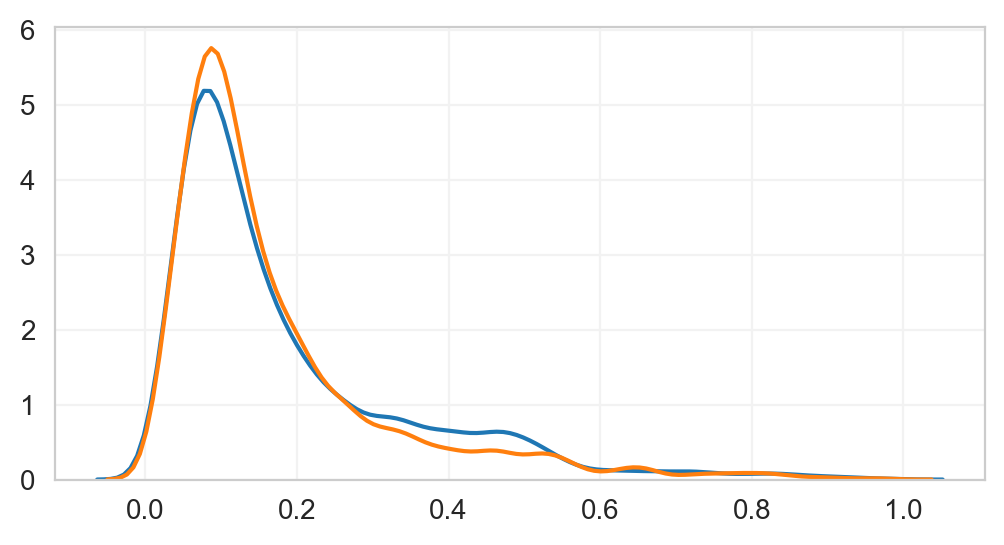

In [33]:
fig = plt.figure(figsize=(6,3))
ax = sns.distplot(max_vafs,kde_kws={'clip': (0.0, 1.0)}, hist=False)
sns.distplot(tp53_max_vafs,kde_kws={'clip': (0.0, 1.0)}, hist=False)
print(len(max_vafs), len(tp53_max_vafs))

## Filtering interesting samples

In [13]:
samples_maxvaf=[]
for sample in list(set(maf_cohort_na_tp53.Tumor_Sample_Barcode)):
    sample_1 = maf_cohort[maf_cohort['Tumor_Sample_Barcode'] == sample]
    if max(sample_1.t_var_freq)>0.15:
        samples_maxvaf.append(sample)

In [14]:
len(samples_maxvaf)

841

In [18]:
# we load clinical data from CBioPortal and take a look to the cancer type involvded
clinical_data = pd.read_csv(data_path + 'cbioportal/raw/mskimpact_clinical_data-2.tsv', sep= '\t')
get_groupby(clinical_data[clinical_data['Sample ID'].isin(samples_maxvaf)], 'Cancer Type', 'count').sort_values(by='count', ascending=False)

,count
Cancer Type,
Non-Small Cell Lung Cancer,177
Colorectal Cancer,138
Pancreatic Cancer,89
Endometrial Cancer,70
Breast Cancer,48
Bladder Cancer,46
Esophagogastric Cancer,35
Prostate Cancer,32
Glioma,28


In [34]:
# Filtering the files on the selected samples
maf_cohort_samples = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples_maxvaf)]
arm_level_samples = arm_level[arm_level['sample'].str[:17].isin(samples_maxvaf)]
annotated_cohort_samples = annotated_cohort[annotated_cohort.tumor_sample.isin(samples_maxvaf)]

In [42]:
mutations = pd.read_pickle(data_path + 'cbioportal/raw/mutations_cohort.pkl')

In [43]:
mutations_filtered = mutations[mutations.sampleId.isin(samples_maxvaf)]

In [44]:
len(set(mutations_filtered.sampleId))

841

In [ ]:
for 